# Introduction

This notebook will use the `/MC/Upgrade/Beam7000GeV-Upgrade-MagDown-Nu7.6-25ns-Pythia8/Sim10aU1/15102320/XDIGI` to study the parameterization of the HLT1 downstream track reconstruction, which include the parameterization for the track extrapolation and the estimation of the size of searching windows.

In order to run this notebook, you have to run first the `downstream_dump` sequence in the HLT1 algorithm and specify the folder in which you have store the output of this sequence.

In [1]:
# The folder of your input JSON files
input_folder = '/hdd/jiahuiz/allen_data/dump/Lb2LambdaGamma_MD/'

# Import packages
All following packages must be installed previously for this notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import json
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
import math
from tqdm import tqdm
import pickle
import sympy as sp
import ROOT
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Welcome to JupyROOT 6.28/00


# Data struct
The internal data struct of this notebook

In [3]:
class ut_hit:
    def __init__(self, data):
        self.id      = data['id']
        self.layer   = data['layer']
        self.xAtYEq0 = data['xAtYEq0']
        self.zAtYEq0 = data['zAtYEq0']
        self.yMax    = data['yMax']
        self.yMid    = data['yMid']
        self.yMin    = data['yMin']
        self.dxdy    = data['dxDy']

In [4]:
class scifi_seed:
    def __init__(self, data, file_id):
        self.hash  = file_id 
        self.event = data['event']
        
        # Seeding output
        self.x   = data['x'  ]
        self.y   = data['y'  ]
        self.z   = data['z'  ]
        self.tx  = data['tx' ]
        self.ty  = data['ty' ]
        self.qop = data['qop']
        
        # Info for ghost
        self.nY    = data['nY'   ]
        self.chi2Y = data['chi2Y']
        self.chi2X = data['chi2X']
        
        # True info
        mc_info = data['matched_mcp']
        self.true_pid     = mc_info['pid'    ]
        self.true_p       = mc_info['p'      ]
        self.true_pt      = mc_info['pt'     ]
        self.true_eta     = mc_info['eta'    ]
        self.true_charge  = mc_info['charge' ]
        self.ovtx_x  = mc_info['ovtx_x' ]
        self.ovtx_y  = mc_info['ovtx_y' ]
        self.ovtx_z  = mc_info['ovtx_z' ]
        
        # Category
        self.fromBeauty  = mc_info['fromBeautyDecay'  ]
        self.fromCharm   = mc_info['fromCharmDecay'   ]
        self.fromStrange = mc_info['fromStrangeDecay' ]
        self.fromSignal  = mc_info['fromSignal'       ]
        
        # Track type
        self.hasSciFi = mc_info['hasSciFi']
        self.hasUT    = mc_info['hasUT'   ]
        self.hasVelo  = mc_info['hasVelo' ]
        self.isLong   = mc_info['isLong'  ]
        self.isDown   = mc_info['isDown'  ]
        
        # UT hits
        self.ut_hits = [ut_hit(h) for h in mc_info['UTHits']]
        

In [5]:
class parameterization:
    def __init__(self, xMagnet, yMagnet, zMagnet, tx, ty, qop):
        self.xMagnet = xMagnet
        self.yMagnet = yMagnet
        self.zMagnet = zMagnet
        self.tx  = tx
        self.ty  = ty
        self.qop = qop

# Input loading

Loading the JSON input is very time consuming, so after the first time we load everything from JSON, we preselect it and stored the preselected data into binary file, then we can quickly reload this data from the stored binary file in the future, which is much faster than reloading everything from JSON.

## Define preselection

In [18]:
def preselection(seed):
    
    # Filter all ghost scifi seeds
    if not seed['is_matched']: return False

    mc_info = seed['matched_mcp']
    
    # Filter not downstream tracks
    is_downstream = not mc_info['hasVelo'] and mc_info['hasUT'] and mc_info['hasSciFi']
    if not is_downstream: return False
    
    # We train only for lambda
    from_lambda = abs(mc_info['mother_pid']) == 3122
    if not from_lambda: return False
    
    # It must fire all layers
    num_hits = lambda seed, layer : len( [1 for h in mc_info['UTHits'] if h['layer'] == layer])
    fire_all_layers = num_hits(seed, 0) > 0 and num_hits(seed, 1) > 0 and num_hits(seed, 2) > 0 and num_hits(seed, 3) > 0
    if not fire_all_layers: return False
    
    # We use good tracks for trainning
    good_tracks = mc_info['eta'] > 2 and mc_info['eta'] < 5
    if not good_tracks: return False
    
    return True

## Load input from JSON

In [7]:
# READ THE FILE ID FROM FILE NAME
def get_file_id(path):
    return path.replace('.json','').split('_')[-1]


# READ FOLDER
all_files = os.listdir(input_folder)
scifi_track_files = [f for f in all_files if 'dump_scifi_tracks_' in f]
file_ids = [get_file_id(f) for f in scifi_track_files]

# PREPARE FILE PATHS
packed_paths = [
    (_ids_, f'{input_folder}/dump_scifi_tracks_{_ids_}.json', f'{input_folder}/dump_ut_hits_{_ids_}.json') for _ids_ in file_ids
]

In [19]:
seeds = []
hits = {}
for (file_id, scifi_path, ut_path) in tqdm(packed_paths):
    # Load scifi
    with open(scifi_path,'r') as f:
        scifi_data = json.loads(f.read())
    seeds += [scifi_seed(s, file_id) for s in scifi_data if preselection(s)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [13:11<00:00,  7.40s/it]


## Save the data into binary file

In [21]:
with open('/hdd/jiahuiz/allen_data/pickle/Extrapolation_Lb2LambdaGammaMD_seeds.pkl', 'wb') as f:
    pickle.dump(seeds, f)

## Reload the data from binary file

In [6]:
with open('/hdd/jiahuiz/allen_data/pickle/Extrapolation_Lb2LambdaGammaMD_seeds.pkl', 'rb') as f:
    seeds = pickle.load(f)

# Data vectorization
To accelerate the study, we vectorize all datas into np.array in order to be able to boost the operations with SIMD

In [7]:
# SciFi info
array_scifi_x     = np.array([s.x     for s in seeds])
array_scifi_y     = np.array([s.y     for s in seeds])
array_scifi_z     = np.array([s.z     for s in seeds])
array_scifi_tx    = np.array([s.tx    for s in seeds])
array_scifi_ty    = np.array([s.ty    for s in seeds])
array_scifi_chi2X = np.array([s.chi2X for s in seeds])
array_scifi_chi2Y = np.array([s.chi2Y for s in seeds])
array_scifi_qop   = np.array([s.qop   for s in seeds])

# Extened SciFi
array_scifi_x0 = array_scifi_x - array_scifi_tx * array_scifi_z
array_scifi_y0 = array_scifi_y - array_scifi_ty * array_scifi_z

# True info
array_true_p       = np.array([s.true_p       for s in seeds])
array_true_pt      = np.array([s.true_pt      for s in seeds])
array_true_charge  = np.array([s.true_charge  for s in seeds])
array_true_qop     = array_true_charge/array_true_p
array_true_abs_qop = abs(array_true_qop)

In [8]:
# Vectorize also the information of firt hit in each layer
def get_first_hit(hits, layer):
    return [h for h in hits if h.layer == layer][0]

# Get first hits
array_hits = [s.ut_hits for s in seeds]
array_hit_layer_0 = [ get_first_hit(hits, 0) for hits in array_hits ]
array_hit_layer_1 = [ get_first_hit(hits, 1) for hits in array_hits ]
array_hit_layer_2 = [ get_first_hit(hits, 2) for hits in array_hits ]
array_hit_layer_3 = [ get_first_hit(hits, 3) for hits in array_hits ]

# Vectorize all infos
# - xAtYEq0
array_hit_layer_0_xAtYEq0 = np.array([h.xAtYEq0 for h in array_hit_layer_0])
array_hit_layer_1_xAtYEq0 = np.array([h.xAtYEq0 for h in array_hit_layer_1])
array_hit_layer_2_xAtYEq0 = np.array([h.xAtYEq0 for h in array_hit_layer_2])
array_hit_layer_3_xAtYEq0 = np.array([h.xAtYEq0 for h in array_hit_layer_3])
# - zAtYEq0
array_hit_layer_0_zAtYEq0 = np.array([h.zAtYEq0 for h in array_hit_layer_0])
array_hit_layer_1_zAtYEq0 = np.array([h.zAtYEq0 for h in array_hit_layer_1])
array_hit_layer_2_zAtYEq0 = np.array([h.zAtYEq0 for h in array_hit_layer_2])
array_hit_layer_3_zAtYEq0 = np.array([h.zAtYEq0 for h in array_hit_layer_3])
# - yMin
array_hit_layer_0_yMin = np.array([h.yMin for h in array_hit_layer_0])
array_hit_layer_1_yMin = np.array([h.yMin for h in array_hit_layer_1])
array_hit_layer_2_yMin = np.array([h.yMin for h in array_hit_layer_2])
array_hit_layer_3_yMin = np.array([h.yMin for h in array_hit_layer_3])
# - yMax
array_hit_layer_0_yMax = np.array([h.yMax for h in array_hit_layer_0])
array_hit_layer_1_yMax = np.array([h.yMax for h in array_hit_layer_1])
array_hit_layer_2_yMax = np.array([h.yMax for h in array_hit_layer_2])
array_hit_layer_3_yMax = np.array([h.yMax for h in array_hit_layer_3])
# - yMid
array_hit_layer_0_yMid = np.array([h.yMid for h in array_hit_layer_0])
array_hit_layer_1_yMid = np.array([h.yMid for h in array_hit_layer_1])
array_hit_layer_2_yMid = np.array([h.yMid for h in array_hit_layer_2])
array_hit_layer_3_yMid = np.array([h.yMid for h in array_hit_layer_3])
# - yWidth
array_hit_layer_0_yWidth = (array_hit_layer_0_yMax - array_hit_layer_0_yMin)/2
array_hit_layer_1_yWidth = (array_hit_layer_1_yMax - array_hit_layer_1_yMin)/2
array_hit_layer_2_yWidth = (array_hit_layer_2_yMax - array_hit_layer_2_yMin)/2
array_hit_layer_3_yWidth = (array_hit_layer_3_yMax - array_hit_layer_3_yMin)/2
# - dxdy
array_hit_layer_0_dxdy = np.array([h.dxdy for h in array_hit_layer_0])
array_hit_layer_1_dxdy = np.array([h.dxdy for h in array_hit_layer_1])
array_hit_layer_2_dxdy = np.array([h.dxdy for h in array_hit_layer_2])
array_hit_layer_3_dxdy = np.array([h.dxdy for h in array_hit_layer_3])

# Data selection

Even we already preselect the data in loading stage, due to the unstable behaviour in the low Pt range, sometimes we would be more interesting to study the parameterization in the high Pt range 

# Define HLT2 parameterization

We define the tracking parameterization from the HLT2 algorithm `PrLongLivedTracking.cpp` to test and check in the HLT1, in case of large deviation we can recompute them and obtain the new parameterization which is the main porpose of this notebook

In [9]:
def hlt2_parameterization_zMagnet(scifi_x, scifi_y, scifi_tx, scifi_ty, scifi_qop):
    return 5379.88 + \
          -2143.93 * scifi_ty**2 + \
           366.124 * scifi_tx**2 + \
           119074  * abs(scifi_qop) + \
          -0.0100333  * abs( scifi_x ) + \
          -0.146055   * abs( scifi_y ) + \
           1260.96    * abs( scifi_ty ) 

In [10]:
def hlt2_parameterization_qop(ut_tx, ut_ty, scifi_tx):
    m_momentumParam = 1217.77 + 454.598 * ut_tx**2 + 3353.39 * ut_ty**2
    return (scifi_tx-ut_tx)/m_momentumParam

In [11]:
def hlt2_parameterization_yMagnet_and_ty(zMagnet, scifi_x, scifi_y, scifi_z, scifi_tx, scifi_ty):
    xMagnet = scifi_x + scifi_tx * (zMagnet - scifi_z)
    slopeX = xMagnet / zMagnet
    dSlope = scifi_tx - slopeX
    dSlope2 = dSlope**2
    by = scifi_y / ( scifi_z + ( 5. * abs( scifi_ty ) * zMagnet + 2000. ) * dSlope2 )
    corrected_ty = by * ( 1. +  5. * abs( by ) * dSlope2 )
    corrected_yMagnet = scifi_y + (zMagnet - scifi_z) * by - 2000. * by * dSlope2
    return corrected_yMagnet, corrected_ty

In [12]:
def hlt2_parameterization(scifi_x, scifi_y, scifi_z, scifi_tx, scifi_ty, scifi_qop):
    # Calculate zMagnet
    zMagnet = hlt2_parameterization_zMagnet(scifi_x, scifi_y, scifi_tx, scifi_ty, scifi_qop)
    # Calculate yMagnet and ty
    yMagnet, ty = hlt2_parameterization_yMagnet_and_ty(zMagnet, scifi_x, scifi_y, scifi_z, scifi_tx, scifi_ty)
    # Calculate xMagnet
    xMagnet = scifi_x + scifi_tx * (zMagnet - scifi_z)
    # Calculate the tx
    tx = xMagnet/zMagnet
    # Calculate the qop
    qop = hlt2_parameterization_qop(tx, ty, scifi_tx)
    
    return parameterization(xMagnet, yMagnet, zMagnet, tx, ty, qop)

# Define useful functions

We can define several helper functions to check the tracking performance and compute parameterization

## profile_plot

Use TProfile with numpy inputs

In [13]:
def profile_plot(x, y, xrange=(0,1), yrange=None, num_bins = 20, title=''):
    rdf = ROOT.RDF.FromNumpy({'x': x, 'y': y})
    tp = rdf.Profile1D(('resolution', '', num_bins, *xrange), 'x', 'y')
    cv = ROOT.TCanvas('cv','')
    tp.SetStats(False)
    tp.SetAxisRange(*yrange, 'Y')
    tp.SetTitle(title)
    tp.Draw()
    return cv.DrawClone()

## slice_and_find_threshold

Useful function for tolerance study, this will slice the y axis into bins and calculate a threshold on each bin

In [14]:
def slice_and_find_threshold(x, y, nbin=(100,100), threshold=95):
    # Make slices
    h, xe, ye = np.histogram2d(x,y,nbin)
    
    # bin width
    xbinw = xe[1]-xe[0]

    # output container
    x_array      = []
    x_max        = []
    
    for i in range(xe.size-1):
        yvals = [ yval for xval, yval in zip(x,y) if (xval>xe[i]) and (xval<=xe[i+1]) ]
        # yvals = y[ (x>xe[i]) & (x<=xe[i+1]) ]
        if len(yvals)>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_max.append( np.percentile(yvals, threshold) )
            
    return np.array(x_array), np.array(x_max)

## dump_poly1d

In [15]:
def dump_poly1d(coeff, varname):
    degree = len(coeff) - 1
    
    equation = ""
    for i in range(degree, -1, -1):
        if i == 0:
            term = f"({coeff[degree - i]:0.6E})"
        elif i == 1:
            term = f"({coeff[degree - i]:0.6E})*{varname}"
        else:
            term = f"({coeff[degree - i]:0.6E})*{varname}^{i}"
            
        equation += term if i == degree else f" + {term}"

    print(equation)

# Calculate expected extrapolation

## Internal classes

In [16]:
class extrapolation:
    def __init__(self, x0, tx, y0, ty, chi2_x, chi2_y):
        self.x0 = x0
        self.tx = tx
        self.y0 = y0
        self.ty = ty
        self.chi2_x = chi2_x
        self.chi2_y = chi2_y
    
    def xAt(self, z):
        return self.x0 + self.tx * z
    
    def yAt(self, z):
        return self.y0 + self.ty * z
    

## Useful functions

In [17]:
def calculate_true_extrapolation(seed : scifi_seed, with_ovtx=True):
    hits = seed.ut_hits
    xxhits = [ h for h in hits if h.layer == 0 or h.layer == 3 ]
    uvhits = [ h for h in hits if h.layer == 1 or h.layer == 2 ]
    
    # Calculate x extrapolation
    xx_x = [ h.xAtYEq0 for h in xxhits ]
    xx_z = [ h.zAtYEq0 for h in xxhits ]
    if with_ovtx:
        xx_x += [seed.ovtx_x]
        xx_z += [seed.ovtx_z]
    tx, x0 = np.polyfit(xx_z, xx_x, 1)
    # if not with_ovtx:
    #     xx_x += [seed.ovtx_x]
    #     xx_z += [seed.ovtx_z]
    chi2_x = np.sum((np.polyval((tx, x0), xx_z) - xx_x) ** 2)
    
    # Calculate y extrapolation
    uv_x = [ x0 + tx * h.zAtYEq0 for h in uvhits ]
    uv_y = [ (hx - h.xAtYEq0)/h.dxdy for hx, h in zip(uv_x, uvhits) ]
    uv_z = [ h.zAtYEq0 for h in uvhits ]
    if with_ovtx:
        uv_y += [seed.ovtx_y]
        uv_z += [seed.ovtx_z]
    ty, y0 = np.polyfit(uv_z, uv_y, 1)
    # if not with_ovtx:
    #     uv_y += [seed.ovtx_y]
    #     uv_z += [seed.ovtx_z]
    chi2_y = np.sum((np.polyval((ty, y0), uv_z) - uv_y) ** 2)
    
    return extrapolation(x0, tx, y0, ty, chi2_x, chi2_y)

## Compute the extrapolation

In [18]:
true_extrapolations = [calculate_true_extrapolation(s, with_ovtx=False) for s in tqdm(seeds, ncols=80)]

100%|█████████████████████████████████| 133475/133475 [00:15<00:00, 8494.78it/s]


In [152]:
array_true_x0      = np.array([t.x0      for t in true_extrapolations])
array_true_tx      = np.array([t.tx      for t in true_extrapolations])
array_true_y0      = np.array([t.y0      for t in true_extrapolations])
array_true_ty      = np.array([t.ty      for t in true_extrapolations])
array_true_chi2_x  = np.array([t.chi2_x  for t in true_extrapolations])
array_true_chi2_y  = np.array([t.chi2_y  for t in true_extrapolations])

In [153]:
array_true_zMagnet = (array_true_x0 - array_scifi_x0) / (array_scifi_tx - array_true_tx)
array_true_xMagnet = array_true_x0 + array_true_tx * array_true_zMagnet
array_true_yMagnet = array_true_y0 + array_true_ty * array_true_zMagnet

# Check the HLT2 parameterization performance

Before starting recompute the parameterization, we should first check the performance of HLT2 parameterization, the following thing are surely clear hints for performance checking:

- Momentum resolution
- Tolerance for each UT layer (both x and y)

In [24]:
hlt2_parameterizations = hlt2_parameterization(array_scifi_x,array_scifi_y,array_scifi_z,array_scifi_tx,array_scifi_ty,array_scifi_qop)
array_hlt2_parameterization_xMagnet = hlt2_parameterizations.xMagnet
array_hlt2_parameterization_yMagnet = hlt2_parameterizations.yMagnet
array_hlt2_parameterization_zMagnet = hlt2_parameterizations.zMagnet
array_hlt2_parameterization_tx      = hlt2_parameterizations.tx
array_hlt2_parameterization_ty      = hlt2_parameterizations.ty
array_hlt2_parameterization_qop     = hlt2_parameterizations.qop
array_hlt2_parameterization_abs_qop = abs(array_hlt2_parameterization_qop)

## Momentum resolution

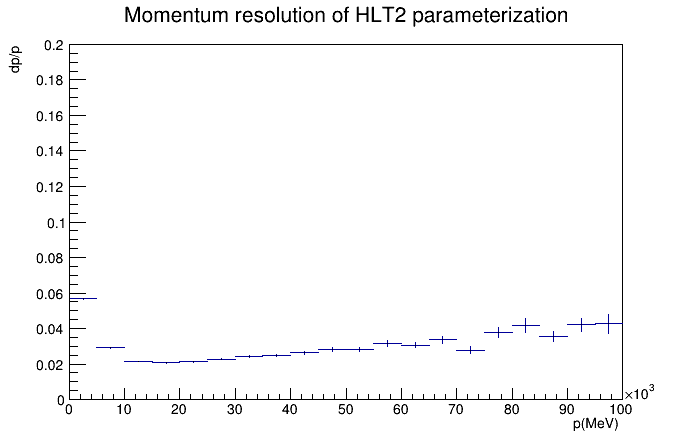

In [25]:
# Get momentum
array_hlt2_parameterization_p = 1/abs(array_hlt2_parameterization_qop)
# Calculate resolution
array_deviation_hlt2_parameterization_p = array_hlt2_parameterization_p - array_true_p
array_resolution_hlt2_parameterization_p = abs(array_deviation_hlt2_parameterization_p)/array_hlt2_parameterization_p
# Plot the profile
profile_plot(
    x = array_hlt2_parameterization_p,
    y = array_resolution_hlt2_parameterization_p,
    xrange = (0, 100e3),
    yrange = (0, 0.2),
    num_bins = 20,
    title = 'Momentum resolution of HLT2 parameterization; p(MeV); dp/p'
)

In [26]:
array_hlt2_parameterization_true_qop = hlt2_parameterization_qop(array_true_tx, array_true_ty, array_scifi_tx)

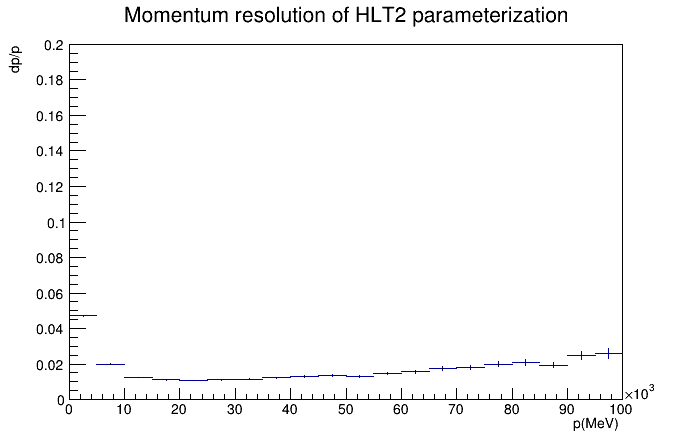

In [27]:
# Get momentum
array_hlt2_parameterization_true_p = 1/abs(array_hlt2_parameterization_true_qop)
# Calculate resolution
array_deviation_hlt2_parameterization_true_p = array_hlt2_parameterization_true_p - array_true_p
array_resolution_hlt2_parameterization_true_p = abs(array_deviation_hlt2_parameterization_true_p)/array_hlt2_parameterization_true_p
# Plot the profile
profile_plot(
    x = array_hlt2_parameterization_p,
    y = array_resolution_hlt2_parameterization_true_p,
    xrange = (0, 100e3),
    yrange = (0, 0.2),
    num_bins = 20,
    title = 'Momentum resolution of HLT2 parameterization; p(MeV); dp/p'
)

# Define functions for parameterization

define helper functions to calculate the linear parameterization

In [28]:
def calculate_parameterization(input_data, target, prefilter = True, reference_model = None, s=0.1, selection =  None):
    features = list(input_data.keys())
    df = pd.DataFrame(input_data)
    df['target'] = target
    
    if reference_model is not None:
        df['reference'] = reference_model
    
    if selection is not None:
        df = df[selection].copy()
        
    # Filter the very very wrong points
    if prefilter:
        mean_target = np.mean(target)
        std_target = np.std(target)
        df = df[ (df['target'] > (mean_target-5*std_target)) & (df['target'] < (mean_target+5*std_target)) ].copy()
    
    
    # Split train and test samples
    X_train, X_test, y_train, y_test = train_test_split(df, df['target'], test_size=0.50, random_state=4)
    
    if reference_model is not None:
        ref_train = X_train.pop('reference')
        ref_test  = X_test.pop('reference')
    
    model = LinearRegression()
    model.fit(X_train[features], y_train)
    
    pred = model.predict(X_test[features])
    
    # Compute scores
    r2_nom = r2_score(y_test, pred)
    
    mse_nom = mean_squared_error(y_test, pred)
    
    rmse_nom = np.sqrt(mean_squared_error(y_test, pred))
    
    mae_nom = mean_absolute_error(y_test, pred)
    
    
    # Tol score
    tol_nom = pred - y_test
    
    cut_nom = np.percentile(np.abs(tol_nom), 98)
    
    mean_nom = tol_nom.mean()
    
    std_nom = tol_nom.std()
    
    # Reference
    if reference_model is not None:
        r2_ref = r2_score(y_test, ref_test)
        mse_ref = mean_squared_error(y_test, ref_test)
        rmse_ref = np.sqrt(mean_squared_error(y_test, ref_test))
        mae_ref = mean_absolute_error(y_test, ref_test)
        tol_ref = ref_test - y_test
        cut_ref = np.percentile(np.abs(tol_ref), 98)
        mean_ref = tol_ref.mean()
        std_ref = tol_ref.std()

    print('--------------------------------------')
    print(' F I T   R E S U L T ')
    print('--------------------------------------')
    
    inter = model.intercept_
    print(f'({inter:.6E})', end='')
    coefs     = list(model.coef_)
    varnames  = X_train.columns.to_list()
    for c, v in zip(coefs, varnames):
        print(f' + ({c:.6E}) * {v}', end='')
    print('')
    print('')
    if reference_model is not None:
        print(f'r2_score               : {r2_nom  } \t ({r2_ref  })')
        print(f'mean_squared_error     : {mse_nom } \t ({mse_ref })')
        print(f'root_mean_squared_error: {rmse_nom} \t ({rmse_ref})')
        print(f'mean_absolute_error    : {mae_nom } \t ({mae_ref })')
        print(f'98% threshold          : {cut_nom } \t ({cut_ref })')
        print(f'deviation mean         : {mean_nom} \t ({mean_ref})')
        print(f'deviation std          : {std_nom } \t ({std_ref })')
    else:
        print(f'r2_score               : {r2_nom}  ')
        print(f'mean_squared_error     : {mse_nom} ')
        print(f'root_mean_squared_error: {rmse_nom}')
        print(f'mean_absolute_error    : {mae_nom} ')
        print(f'98% threshold          : {cut_nom} ')
        print(f'deviation mean         : {mean_nom}')
        print(f'deviation std          : {std_nom} ')
    
    print('--------------------------------------')
    
    plt.scatter(x=pred,y=pred-y_test, s=s);
    plt.xlabel('Expected value')
    plt.ylabel('Bias')
    
    
    # print(model)
    
    # return model.predict(df[features])

# zMagnet

--------------------------------------
 F I T   R E S U L T 
--------------------------------------
(5.367359E+03) + (-2.660298E+03) * scifi_ty*scifi_ty + (3.253875E+02) * scifi_tx*scifi_tx + (-4.985715E+03) * qop + (-2.634312E-02) * abs(scifi_x) + (-6.648777E-02) * abs(scifi_y) + (7.241572E+02) * abs(scifi_ty) + (1.482586E+02) * abs(scifi_tx)

r2_score               : 0.5932188983299527  
mean_squared_error     : 700.0496554563423 
root_mean_squared_error: 26.458451493924247
mean_absolute_error    : 15.67182556529792 
98% threshold          : 78.09093557968116 
deviation mean         : -0.14505758981297576
deviation std          : 26.45825279516702 
--------------------------------------


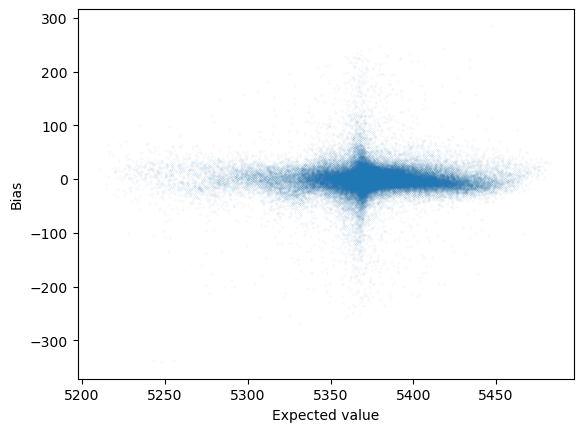

In [29]:
# train_selection = (array_true_p > 5000) & (array_true_pt > 1000)

calculate_parameterization(
    input_data={
        'scifi_ty*scifi_ty' : array_scifi_ty**2,
        'scifi_tx*scifi_tx' : array_scifi_tx**2,
        'qop' : array_true_qop,
        'abs(scifi_x)' : abs(array_scifi_x),
        'abs(scifi_y)' : abs(array_scifi_y),
        'abs(scifi_ty)' : abs(array_scifi_ty),
        'abs(scifi_tx)' : abs(array_scifi_tx),
    },
    target=array_true_zMagnet,
    s=0.001,
    # selection=train_selection
)

In [30]:
def new_parameterization_zMagnet(scifi_x, scifi_y, scifi_z, scifi_tx, scifi_ty, qop):
    # return (5.365882E+03) + (-3.077896E+03) * scifi_ty*scifi_ty + (1.457430E+02) * scifi_tx*scifi_tx + (-1.380292E+04) * qop + (-2.703781E-02) * abs(scifi_x) + (-6.115305E-02) * abs(scifi_y) + (7.810298E+02) * abs(scifi_ty) + (1.651933E+02) * abs(scifi_tx)
    return (5.367359E+03) + (-2.660298E+03) * scifi_ty*scifi_ty + (3.253875E+02) * scifi_tx*scifi_tx + (-4.985715E+03) * qop + (-2.634312E-02) * abs(scifi_x) + (-6.648777E-02) * abs(scifi_y) + (7.241572E+02) * abs(scifi_ty) + (1.482586E+02) * abs(scifi_tx)

array_new_parameterization_zMagnet = new_parameterization_zMagnet(
    scifi_x = array_scifi_x,
    scifi_y = array_scifi_y,
    scifi_z = array_scifi_z,
    scifi_tx = array_scifi_tx,
    scifi_ty = array_scifi_ty,
    qop = array_scifi_qop
)

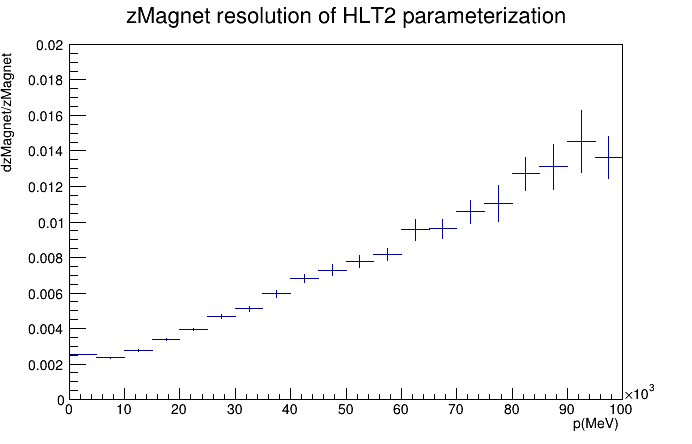

In [31]:
# Calculate resolution
array_deviation_new_parameterization_zMagnet = array_new_parameterization_zMagnet - array_true_zMagnet
array_resolution_new_parameterization_zMagnet = abs(array_deviation_new_parameterization_zMagnet)/array_new_parameterization_zMagnet
# Plot the profile
profile_plot(
    x = array_true_p,
    y = array_resolution_new_parameterization_zMagnet,
    xrange = (0, 100e3),
    yrange = (0, 0.02),
    num_bins = 20,
    title = 'zMagnet resolution of HLT2 parameterization; p(MeV); dzMagnet/zMagnet'
)

# Y correction

--------------------------------------
 F I T   R E S U L T 
--------------------------------------
(-5.130062E-01) + (1.409223E-01) * y + (-1.470980E+03) * ty + (-2.317281E+05) * qop

r2_score               : 0.516006399553796  
mean_squared_error     : 1436.2730595992232 
root_mean_squared_error: 37.898193355346415
mean_absolute_error    : 27.937854204528705 
98% threshold          : 101.45205616044657 
deviation mean         : -0.08964010385984068
deviation std          : 37.89837154197666 
--------------------------------------


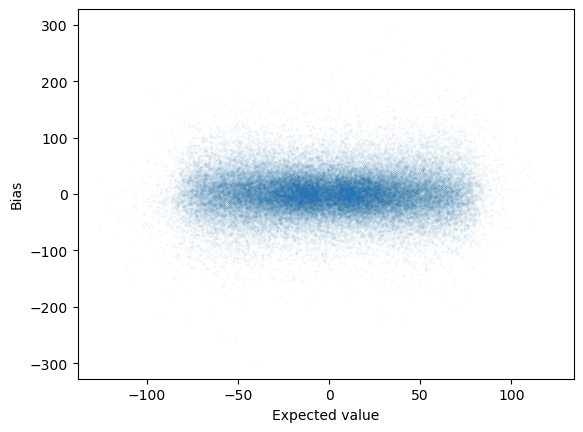

In [175]:
# Y correction
# train_selection = (array_true_p > 5e3) & (array_true_pt > 1e3)
array_true_scifi_y = array_true_y0 + array_true_ty * array_scifi_z
array_true_correction_scifi_y = array_true_scifi_y - array_scifi_y

calculate_parameterization(
    input_data={
        'y' : array_scifi_y,
        'ty' : array_scifi_ty,
        'qop': array_scifi_qop,
    },
    target=array_true_correction_scifi_y,
    s=0.001,
    # selection=train_selection
)

In [178]:
def parameterization_correction_scifi_y(y, ty, qop):
    return (-5.130062E-01) + (1.409223E-01) * y + (-1.470980E+03) * ty + (-2.317281E+05) * qop
    # return (-5.130062E-01) + (1.409223E-01) * y + (-1.470980E+03) * ty + (-2.317281E+05) * qop
    # return (-5.027418E-01) + (1.406906E-01) * y + (-1.468687E+03) * ty + (-2.389273E+05) * qop
    # return (-5.130062E-01) + (1.409223E-01) * y + (-1.470980E+03) * ty + (-2.317281E+05) * qop

array_new_parameterization_expected_correction_scifi_y = parameterization_correction_scifi_y(
    y = array_scifi_y,
    ty = array_scifi_ty,
    qop = array_scifi_qop
)
array_new_parameterization_expected_scifi_y = array_scifi_y + array_new_parameterization_expected_correction_scifi_y

--------------------------------------
 F I T   R E S U L T 
--------------------------------------
(-5.468134E-05) + (6.705295E-05) * y + (-6.321917E-01) * ty + (-3.407640E+01) * qop

r2_score               : 0.5131729714733626  
mean_squared_error     : 3.431061331513381e-05 
root_mean_squared_error: 0.005857526211220382
mean_absolute_error    : 0.004297162944866602 
98% threshold          : 0.015649928453483827 
deviation mean         : -3.523662514732694e-05
deviation std          : 0.005857464155535591 
--------------------------------------


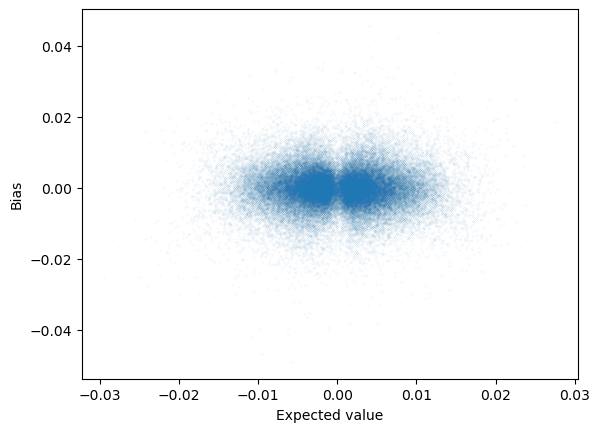

In [179]:
# ty correction
# array_true_correction_ty =  array_true_ty - array_scifi_ty

calculate_parameterization(
    input_data={
        'y' : array_scifi_y,
        'ty' : array_scifi_ty,
        'qop': array_scifi_qop,
    },
    target=array_true_correction_ty,
    s=0.001,
    # selection=train_selection
)

In [180]:
def parameterization_correction_ty(y, ty, qop):
    # return (-5.468134E-05) + (6.705295E-05) * y + (-6.321917E-01) * ty + (-3.407640E+01) * qop
    # return (-5.318066E-05) + (6.700351E-05) * y + (-6.317000E-01) * ty + (-3.514267E+01) * qop
    # return (-4.560061E-05) + (-3.641208E+01) * qop
    return (-5.468134E-05) + (6.705295E-05) * y + (-6.321917E-01) * ty + (-3.407640E+01) * qop

array_new_parameterization_expected_correction_ty = parameterization_correction_ty(
    y = array_scifi_y,
    ty = array_scifi_ty,
    qop = array_scifi_qop
)
array_new_parameterization_expected_ty = array_scifi_ty + array_new_parameterization_expected_correction_ty

## Cross check

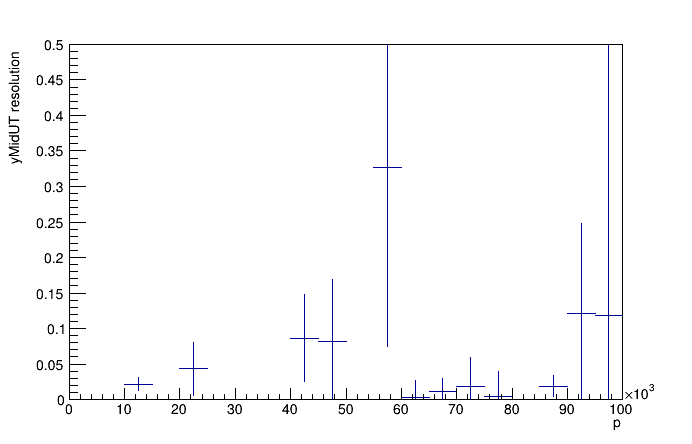

In [181]:
# Calculate true yMidUT
zMidUT = 2484.6
array_true_yMidUT = array_true_y0 + array_true_ty * zMidUT
# Calculate our expected y MidUT
array_new_parameterization_expected_yMidUT = array_new_parameterization_expected_scifi_y + array_new_parameterization_expected_ty * (zMidUT - array_scifi_z)
# Calculatte resolution
array_deviation_new_parameterization_expected_yMidUT = array_new_parameterization_expected_yMidUT - array_true_yMidUT
array_resolution_new_parameterization_expected_yMidUT = abs(array_deviation_new_parameterization_expected_yMidUT)/array_new_parameterization_expected_yMidUT
# Plot the profile

profile_plot(
    x = array_true_p,
    y = array_resolution_new_parameterization_expected_yMidUT,
    xrange = (0, 100e3),
    yrange = (0, 0.5),
    num_bins = 20,
    title = '; p; yMidUT resolution'
)

# First slope

--------------------------------------
 F I T   R E S U L T 
--------------------------------------
(2.247261E-05) + (-8.680666E-05) * ty + (8.003155E+00) * qop

r2_score               : 0.10577790369743312  
mean_squared_error     : 1.2986529771657304e-05 
root_mean_squared_error: 0.0036036828067488548
mean_absolute_error    : 0.0021210342229630334 
98% threshold          : 0.011828369549440314 
deviation mean         : 3.918889373037469e-06
deviation std          : 0.003603707862732899 
--------------------------------------


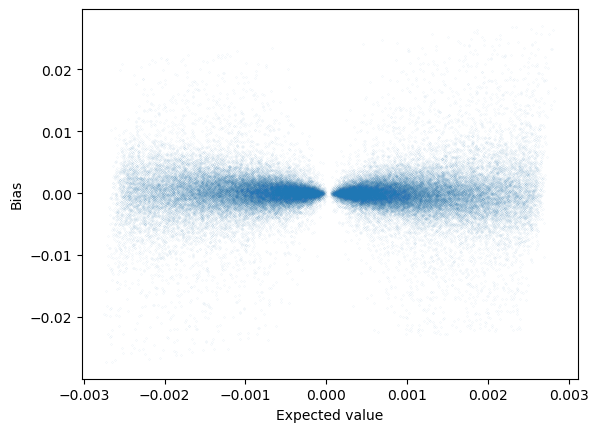

In [182]:
# Estimate xMagnet 
array_new_parameterization_xMagnet = array_scifi_x + array_scifi_tx * (array_new_parameterization_zMagnet - array_scifi_z)
# Calculate first slope
array_new_parameterization_true_first_slope = (array_hit_layer_3_xAtYEq0 - array_new_parameterization_xMagnet) / (array_hit_layer_3_zAtYEq0 - array_new_parameterization_zMagnet)
# Calculate expected first slope
array_new_parameterization_expected_first_slope = array_new_parameterization_xMagnet/array_new_parameterization_zMagnet
# Estimate the correction
array_new_parameterization_true_correction_first_slope = array_new_parameterization_true_first_slope - array_new_parameterization_expected_first_slope

calculate_parameterization(
    input_data={
        'ty' : array_true_ty,
        'qop': array_true_qop,
    },
    target=array_new_parameterization_true_correction_first_slope,
    s=0.001,
    # selection=train_selection
)

In [183]:
def parameterization_correction_first_slope(y, ty, qop):
    return (2.247261E-05) + (-8.680666E-05) * ty + (8.003155E+00) * qop

array_new_parameterization_expected_correction_first_slope = parameterization_correction_first_slope(
    y = array_scifi_y,
    ty = array_scifi_ty,
    qop = array_scifi_qop
)

# Tolerance study

## First hit

In [302]:
# Estimate first tx
array_new_parameterization_expected_tx = array_new_parameterization_expected_first_slope + array_new_parameterization_expected_correction_first_slope
# yMagnet
array_new_parameterization_yMagnet = array_new_parameterization_expected_scifi_y + array_new_parameterization_expected_ty * (array_new_parameterization_zMagnet - array_scifi_z)
# Estimate expected position y
array_new_parameterization_layer_3_y = array_new_parameterization_yMagnet + array_new_parameterization_expected_ty * ( array_hit_layer_3_zAtYEq0 - array_new_parameterization_zMagnet )
# Estimate expected position x
array_new_parameterization_layer_3_x = array_new_parameterization_xMagnet + array_new_parameterization_expected_tx * ( array_hit_layer_3_zAtYEq0 - array_new_parameterization_zMagnet )
# Calculate deviation
array_deviation_new_parameterization_layer_3_x = array_new_parameterization_layer_3_x - (array_hit_layer_3_xAtYEq0)
array_deviation_new_parameterization_layer_3_y = array_new_parameterization_layer_3_y - (array_hit_layer_3_yMid)
# Calculate tolerance
array_tolerance_new_parameterization_layer_3_x = abs(array_deviation_new_parameterization_layer_3_x)
array_tolerance_new_parameterization_layer_3_y = abs(array_deviation_new_parameterization_layer_3_y) - array_hit_layer_3_yWidth
array_tolerance_new_parameterization_layer_3_y[array_tolerance_new_parameterization_layer_3_y<0] = 0
# Calculate expected qop
array_first_hit_expected_qop = hlt2_parameterization_qop(array_new_parameterization_expected_first_slope, array_new_parameterization_expected_ty, array_scifi_tx)
array_first_hit_expected_abs_qop = abs(array_first_hit_expected_qop)

max: 57.71
(2.011148E+05)*qop + (2.836915E+00)


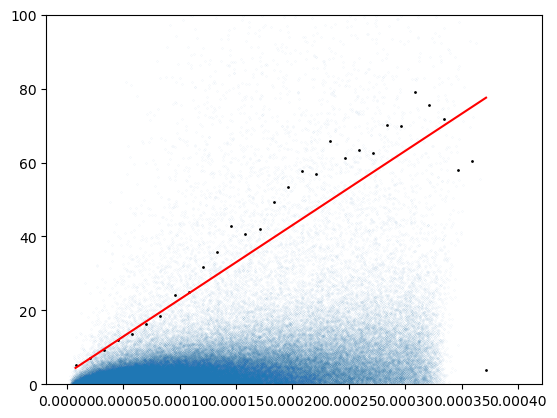

In [327]:
# Get threshols
p_x, p_y = slice_and_find_threshold(
    x = array_first_hit_expected_abs_qop, 
    y = array_tolerance_new_parameterization_layer_3_x,
    threshold=98,
    nbin=(30, 100)
)

print('max:', round(np.percentile(array_tolerance_new_parameterization_layer_3_x, 99.), 2))

# # Fit
# fit_range = (p_x>0)  & (p_x<0.1e-3)
# coeff = np.polyfit(p_x[fit_range],p_y[fit_range],1)
# func = np.poly1d(coeff)

# fit_range2 = (p_x>0.1e-3)  & (p_x<0.3e-3)
# coeff2 = np.polyfit(p_x[fit_range2],p_y[fit_range2],1)
# func2 = np.poly1d(coeff2)

# # Plot
# plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_3_x, s=0.01, alpha=0.8)
# plt.scatter(x=p_x, y=p_y, s=1, color='black')
# plt.plot(p_x,func(p_x), 'g-')
# plt.plot(p_x,func2(p_x), 'r-')

# # Views
# plt.ylim(0, 40)
# dump_poly1d(coeff,'qop')
# dump_poly1d(coeff2,'qop')



# Fit
fit_range = p_x<0.10e-3 
coeff = np.polyfit(p_x[fit_range],p_y[fit_range],1)
func = np.poly1d(coeff)

# Plot
plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_3_x, s=0.001, alpha=0.8)
plt.scatter(x=p_x, y=p_y, s=1, color='black')
plt.plot(p_x,func(p_x), 'r-')

# Views
plt.ylim(0, 100)

dump_poly1d(coeff,'qop')

max: 21.28
intersection:  1.738364e-04
(2.575863E+04)*qop + (5.166317E+00)


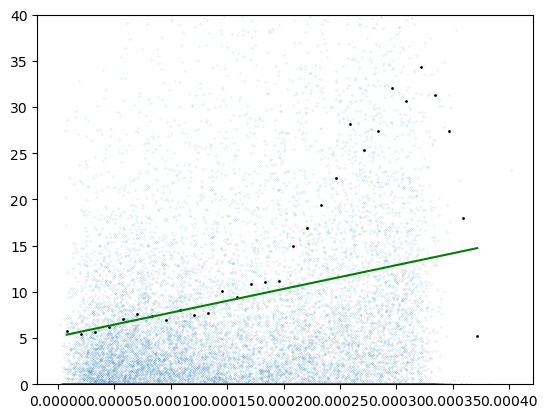

In [335]:
# Get threshols
p_x, p_y = slice_and_find_threshold(
    x = array_first_hit_expected_abs_qop, 
    y = array_tolerance_new_parameterization_layer_3_y,
    threshold=98,
    nbin=(30, 100)
)

print('max:', round(np.percentile(array_tolerance_new_parameterization_layer_3_y, 99), 2))

# Fit
fit_range = (p_x>0)  & (p_x<0.17e-3)
coeff = np.polyfit(p_x[fit_range],p_y[fit_range],1)
func = np.poly1d(coeff)

fit_range2 = (p_x>0.17e-3)  & (p_x<0.25e-3)
coeff2 = np.polyfit(p_x[fit_range2],p_y[fit_range2],1)
func2 = np.poly1d(coeff2)

print(f'intersection: {(coeff[1] - coeff2[1])/(coeff2[0] - coeff[0]) : 0.6e}')

# Plot
plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_3_y, s=0.01, alpha=0.8)
plt.scatter(x=p_x, y=p_y, s=1, color='black')
plt.plot(p_x,func(p_x), 'g-')
# plt.plot(p_x,func2(p_x), 'r-')

# Views
plt.ylim(0, 40)
dump_poly1d(coeff,'qop')
# dump_poly1d(coeff2,'qop')

## Rest hits

In [311]:
# Estimate expected position y
array_new_parameterization_layer_0_y = array_new_parameterization_yMagnet + array_new_parameterization_expected_ty * ( array_hit_layer_0_zAtYEq0 - array_new_parameterization_zMagnet )
array_new_parameterization_layer_1_y = array_new_parameterization_yMagnet + array_new_parameterization_expected_ty * ( array_hit_layer_1_zAtYEq0 - array_new_parameterization_zMagnet )
array_new_parameterization_layer_2_y = array_new_parameterization_yMagnet + array_new_parameterization_expected_ty * ( array_hit_layer_2_zAtYEq0 - array_new_parameterization_zMagnet )

# Apply tx correction
array_new_parameterization_corrected_tx = (array_new_parameterization_xMagnet - array_hit_layer_3_xAtYEq0) / (array_new_parameterization_zMagnet - array_hit_layer_3_zAtYEq0)

# Estimate expected position x
array_new_parameterization_layer_0_x = array_new_parameterization_xMagnet + array_new_parameterization_corrected_tx * ( array_hit_layer_0_zAtYEq0 - array_new_parameterization_zMagnet )
array_new_parameterization_layer_1_x = array_new_parameterization_xMagnet + array_new_parameterization_corrected_tx * ( array_hit_layer_1_zAtYEq0 - array_new_parameterization_zMagnet )
array_new_parameterization_layer_2_x = array_new_parameterization_xMagnet + array_new_parameterization_corrected_tx * ( array_hit_layer_2_zAtYEq0 - array_new_parameterization_zMagnet )

# Estimate x deviations
array_deviation_new_parameterization_layer_0_x = array_new_parameterization_layer_0_x - (array_hit_layer_0_xAtYEq0 + array_hit_layer_0_dxdy * array_new_parameterization_layer_0_y)
array_deviation_new_parameterization_layer_1_x = array_new_parameterization_layer_1_x - (array_hit_layer_1_xAtYEq0 + array_hit_layer_1_dxdy * array_new_parameterization_layer_1_y)
array_deviation_new_parameterization_layer_2_x = array_new_parameterization_layer_2_x - (array_hit_layer_2_xAtYEq0 + array_hit_layer_2_dxdy * array_new_parameterization_layer_2_y)

# Estimate x tolerance
array_tolerance_new_parameterization_layer_0_x = abs(array_deviation_new_parameterization_layer_0_x)
array_tolerance_new_parameterization_layer_1_x = abs(array_deviation_new_parameterization_layer_1_x)
array_tolerance_new_parameterization_layer_2_x = abs(array_deviation_new_parameterization_layer_2_x)

# Estimate y deviations
array_deviation_new_parameterization_layer_0_y = array_new_parameterization_layer_0_y - (array_hit_layer_0_yMid)
array_deviation_new_parameterization_layer_1_y = array_new_parameterization_layer_1_y - (array_hit_layer_1_yMid)
array_deviation_new_parameterization_layer_2_y = array_new_parameterization_layer_2_y - (array_hit_layer_2_yMid)

# Estimate y tolerance
array_tolerance_new_parameterization_layer_0_y = abs(array_deviation_new_parameterization_layer_0_y) - array_hit_layer_0_yWidth
array_tolerance_new_parameterization_layer_1_y = abs(array_deviation_new_parameterization_layer_1_y) - array_hit_layer_1_yWidth
array_tolerance_new_parameterization_layer_2_y = abs(array_deviation_new_parameterization_layer_2_y) - array_hit_layer_2_yWidth

# Normalization
array_tolerance_new_parameterization_layer_0_y[array_tolerance_new_parameterization_layer_0_y<0] = 0
array_tolerance_new_parameterization_layer_1_y[array_tolerance_new_parameterization_layer_1_y<0] = 0
array_tolerance_new_parameterization_layer_2_y[array_tolerance_new_parameterization_layer_2_y<0] = 0

# Calculate expected qop
array_rest_hit_expected_qop = hlt2_parameterization_qop(array_new_parameterization_corrected_tx, array_new_parameterization_expected_ty, array_scifi_tx)
array_rest_hit_expected_abs_qop = abs(array_rest_hit_expected_qop)

max: 1.92
(4.932216E+03)*qop + (4.622822E-01)


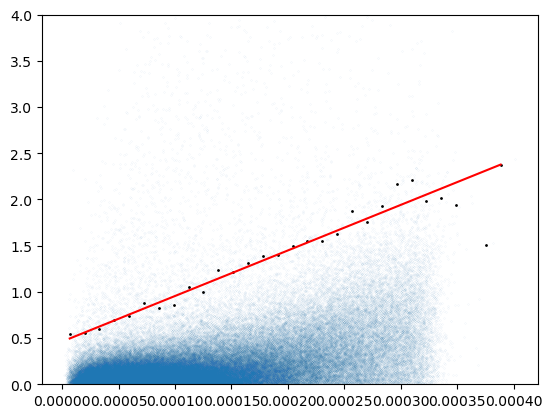

In [328]:
# Get threshols
p_x, p_y = slice_and_find_threshold(
    x = array_rest_hit_expected_abs_qop, 
    y = array_tolerance_new_parameterization_layer_0_x,
    threshold=98,
    nbin=(30, 100)
)

print('max:', round(np.percentile(array_tolerance_new_parameterization_layer_0_x, 99.), 2))

# # Fit
# fit_range = (p_x>0)  & (p_x<0.10e-3)
# coeff = np.polyfit(p_x[fit_range],p_y[fit_range],1)
# func = np.poly1d(coeff)

# fit_range2 = (p_x>0.10e-3)  & (p_x<0.3e-3)
# coeff2 = np.polyfit(p_x[fit_range2],p_y[fit_range2],1)
# func2 = np.poly1d(coeff2)

# # Plot
# plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_0_x, s=0.01, alpha=0.8)
# plt.scatter(x=p_x, y=p_y, s=1, color='black')
# plt.plot(p_x,func(p_x), 'g-')
# plt.plot(p_x,func2(p_x), 'r-')

# # Views
# plt.ylim(0, 2)
# dump_poly1d(coeff,'qop')
# dump_poly1d(coeff2,'qop')

# Fit
fit_range = p_x<0.25e-3 
coeff = np.polyfit(p_x[fit_range],p_y[fit_range],1)
func = np.poly1d(coeff)


# Plot
plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_0_x, s=0.001, alpha=0.8)
plt.scatter(x=p_x, y=p_y, s=1, color='black')
plt.plot(p_x,func(p_x), 'r-')
# Views
plt.ylim(0, 4)
dump_poly1d(coeff,'qop')

max: 4.93
(4.229975E+07)*qop^2 + (3.339328E+03)*qop + (1.775429E+00)


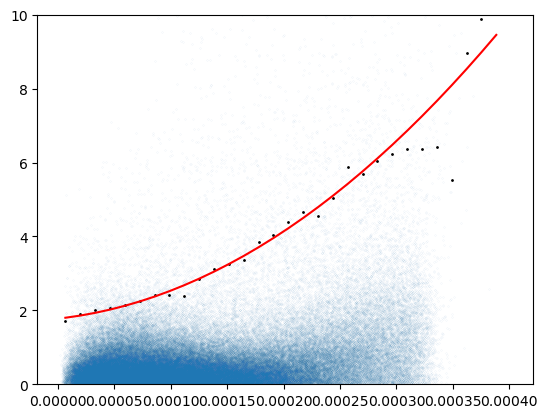

In [329]:
# Get threshols
p_x, p_y = slice_and_find_threshold(
    x = array_rest_hit_expected_abs_qop, 
    y = array_tolerance_new_parameterization_layer_1_x,
    threshold=98.,
    nbin=(30, 100)
)
print('max:', round(np.percentile(array_tolerance_new_parameterization_layer_1_x, 99.), 2))

# # Fit
# fit_range = (p_x>0)  & (p_x<0.15e-3)
# coeff = np.polyfit(p_x[fit_range],p_y[fit_range],1)
# func = np.poly1d(coeff)

# fit_range2 = (p_x>0.15e-3)  & (p_x<0.3e-3)
# coeff2 = np.polyfit(p_x[fit_range2],p_y[fit_range2],1)
# func2 = np.poly1d(coeff2)

# # Plot
# plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_1_x, s=0.01, alpha=0.8)
# plt.scatter(x=p_x, y=p_y, s=1, color='black')
# plt.plot(p_x,func(p_x), 'g-')
# plt.plot(p_x,func2(p_x), 'r-')

# # Views
# plt.ylim(0, 6)
# dump_poly1d(coeff,'qop')
# dump_poly1d(coeff2,'qop')

# Fit
fit_range = p_x<0.25e-3 
coeff = np.polyfit(p_x[fit_range],p_y[fit_range],2)
func = np.poly1d(coeff)
# Plot
plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_1_x, s=0.001, alpha=0.8)
plt.scatter(x=p_x, y=p_y, s=1, color='black')
plt.plot(p_x,func(p_x), 'r-')
# Views
plt.ylim(0, 10)
dump_poly1d(coeff,'qop')

max: 4.25
(3.973958E+07)*qop^2 + (1.400553E+03)*qop + (1.760519E+00)


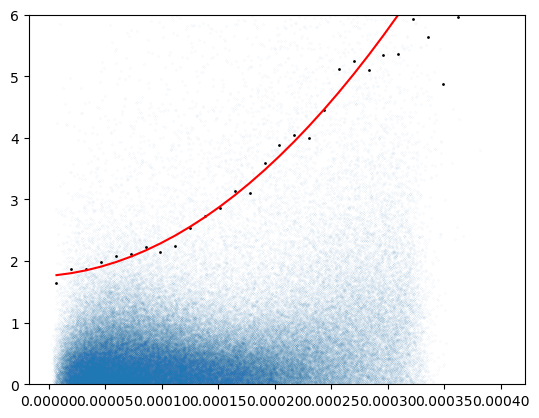

In [333]:
# Get threshols
p_x, p_y = slice_and_find_threshold(
    x = array_rest_hit_expected_abs_qop, 
    y = array_tolerance_new_parameterization_layer_2_x,
    threshold=98,
    nbin=(30, 100)
)
print('max:', round(np.percentile(array_tolerance_new_parameterization_layer_2_x, 99), 2))

# # Fit
# fit_range = (p_x>0)  & (p_x<0.15e-3)
# coeff = np.polyfit(p_x[fit_range],p_y[fit_range],1)
# func = np.poly1d(coeff)

# fit_range2 = (p_x>0.15e-3)  & (p_x<0.3e-3)
# coeff2 = np.polyfit(p_x[fit_range2],p_y[fit_range2],1)
# func2 = np.poly1d(coeff2)

# # Plot
# plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_2_x, s=0.01, alpha=0.8)
# plt.scatter(x=p_x, y=p_y, s=1, color='black')
# plt.plot(p_x,func(p_x), 'g-')
# plt.plot(p_x,func2(p_x), 'r-')

# # Views
# plt.ylim(0, 4)
# dump_poly1d(coeff,'qop')
# dump_poly1d(coeff2,'qop')


# Fit
fit_range = p_x<0.25e-3 
coeff = np.polyfit(p_x[fit_range],p_y[fit_range],2)
func = np.poly1d(coeff)
# Plot
plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_2_x, s=0.001, alpha=0.8)
plt.scatter(x=p_x, y=p_y, s=1, color='black')
plt.plot(p_x,func(p_x), 'r-')
# Views
plt.ylim(0, 6)
dump_poly1d(coeff,'qop')

max: 23.72
intersection:  1.578118e-04
(2.926494E+04)*qop + (5.932930E+00)


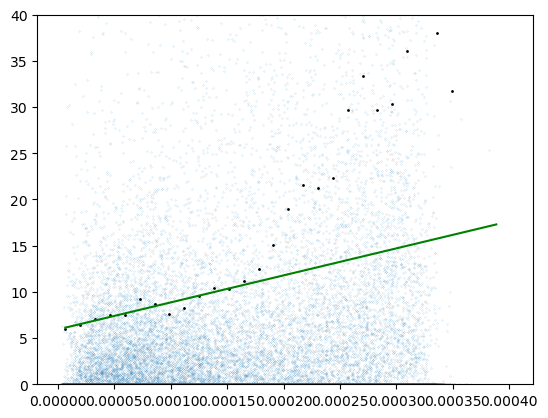

In [337]:
# Get threshols
p_x, p_y = slice_and_find_threshold(
    x = array_rest_hit_expected_abs_qop, 
    y = array_tolerance_new_parameterization_layer_0_y,
    threshold=98,
    nbin=(30, 100)
)

print('max:', round(np.percentile(array_tolerance_new_parameterization_layer_0_y, 99), 2))

# Fit
fit_range = (p_x>0)  & (p_x<0.17e-3)
coeff = np.polyfit(p_x[fit_range],p_y[fit_range],1)
func = np.poly1d(coeff)

fit_range2 = (p_x>0.17e-3)  & (p_x<0.25e-3)
coeff2 = np.polyfit(p_x[fit_range2],p_y[fit_range2],1)
func2 = np.poly1d(coeff2)

# print(f'intersection: {(coeff[1] - coeff2[1])/(coeff2[0] - coeff[0]) : 0.6e}')

# Plot
plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_0_y, s=0.01, alpha=0.8)
plt.scatter(x=p_x, y=p_y, s=1, color='black')
plt.plot(p_x,func(p_x), 'g-')
# plt.plot(p_x,func2(p_x), 'r-')

# Views
plt.ylim(0, 40)
dump_poly1d(coeff,'qop')
# dump_poly1d(coeff2,'qop')

max: 22.86
(2.384459E+04)*qop + (6.367733E+00)


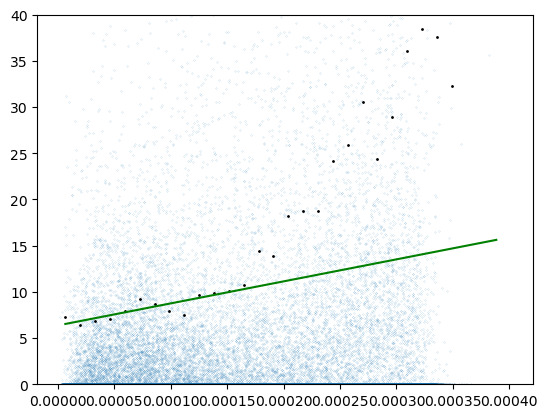

In [341]:
# Get threshols
p_x, p_y = slice_and_find_threshold(
    x = array_rest_hit_expected_abs_qop, 
    y = array_tolerance_new_parameterization_layer_1_y,
    threshold=98,
    nbin=(30, 100)
)
print('max:', round(np.percentile(array_tolerance_new_parameterization_layer_1_y, 99), 2))

# Fit
fit_range = (p_x>0)  & (p_x<0.17e-3)
coeff = np.polyfit(p_x[fit_range],p_y[fit_range],1)
func = np.poly1d(coeff)

fit_range2 = (p_x>0.17e-3)  & (p_x<0.25e-3)
coeff2 = np.polyfit(p_x[fit_range2],p_y[fit_range2],1)
func2 = np.poly1d(coeff2)

# print(f'intersection: {(coeff[1] - coeff2[1])/(coeff2[0] - coeff[0]) : 0.6e}')

# Plot
plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_1_y, s=0.01, alpha=0.8)
plt.scatter(x=p_x, y=p_y, s=1, color='black')
plt.plot(p_x,func(p_x), 'g-')
# plt.plot(p_x,func2(p_x), 'r-')

# Views
plt.ylim(0, 40)
dump_poly1d(coeff,'qop')
# dump_poly1d(coeff2,'qop')

max: 21.44
(3.128338E+04)*qop + (4.971600E+00)


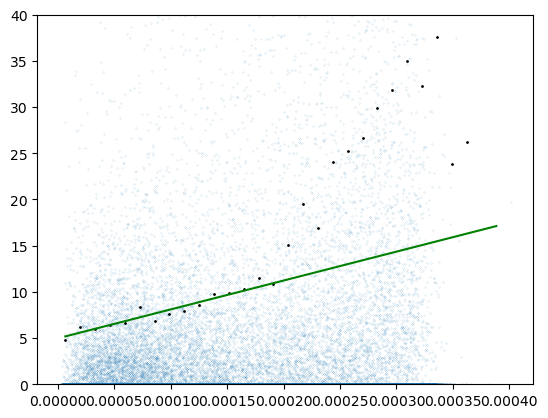

In [340]:
# Get threshols
p_x, p_y = slice_and_find_threshold(
    x = array_rest_hit_expected_abs_qop, 
    y = array_tolerance_new_parameterization_layer_2_y,
    threshold=98,
    nbin=(30, 100)
)

print('max:', round(np.percentile(array_tolerance_new_parameterization_layer_2_y, 99), 2))

# Fit
fit_range = (p_x>0)  & (p_x<0.17e-3)
coeff = np.polyfit(p_x[fit_range],p_y[fit_range],1)
func = np.poly1d(coeff)

fit_range2 = (p_x>0.17e-3)  & (p_x<0.25e-3)
coeff2 = np.polyfit(p_x[fit_range2],p_y[fit_range2],1)
func2 = np.poly1d(coeff2)

# print(f'intersection: {(coeff[1] - coeff2[1])/(coeff2[0] - coeff[0]) : 0.6e}')

# Plot
plt.scatter(x=array_true_abs_qop, y=array_tolerance_new_parameterization_layer_2_y, s=0.01, alpha=0.8)
plt.scatter(x=p_x, y=p_y, s=1, color='black')
plt.plot(p_x,func(p_x), 'g-')
# plt.plot(p_x,func2(p_x), 'r-')

# Views
plt.ylim(0, 40)
dump_poly1d(coeff,'qop')
# dump_poly1d(coeff2,'qop')